# ***Data Science Workshop - Google Quest*** 

# **Libraries import:** 

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from bert_tokenization import bertTokenization as tokenization
import tensorflow.keras.backend as K
import gc
from scipy.stats import spearmanr
import seaborn as sns
import amen_script as modBert

np.set_printoptions(suppress=True)

C:\Users\elirane\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# **Dataset upload:** 

In [4]:
PATH = 'input/Data/'
BERT_PATH = 'input/bert-base-from-tfhub/bert_en_uncased_L-12_H-768_A-12'
tokenizer = tokenization.FullTokenizer(BERT_PATH+'/assets/vocab.txt', True)
MAX_SEQUENCE_LENGTH = 512

df_train = pd.read_csv(PATH+'train.csv')
df_test = pd.read_csv(PATH+'test.csv')
df_sub = pd.read_csv(PATH+'sample_submission.csv')

##remove later!!!!!!!!!!!!!!!!!!!!!!!
df_train = df_train[:10]
df_test = df_test[:10]
df_sub = df_sub[:10]

print('train shape =', df_train.shape)
print('test shape =PATH', df_test.shape)

train shape = (10, 41)
test shape =PATH (10, 11)


In [5]:
df_train.head(3)

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,...,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,...,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889


In [6]:
df_test.head(3)

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host
0,39,Will leaving corpses lying around upset my pri...,I see questions/information online about how t...,Dylan,https://gaming.stackexchange.com/users/64471,There is no consequence for leaving corpses an...,Nelson868,https://gaming.stackexchange.com/users/97324,http://gaming.stackexchange.com/questions/1979...,CULTURE,gaming.stackexchange.com
1,46,Url link to feature image in the portfolio,I am new to Wordpress. i have issue with Featu...,Anu,https://wordpress.stackexchange.com/users/72927,I think it is possible with custom fields.\r\n...,Irina,https://wordpress.stackexchange.com/users/27233,http://wordpress.stackexchange.com/questions/1...,TECHNOLOGY,wordpress.stackexchange.com
2,70,"Is accuracy, recoil or bullet spread affected ...","To experiment I started a bot game, toggled in...",Konsta,https://gaming.stackexchange.com/users/37545,You do not have armour in the screenshots. Thi...,Damon Smithies,https://gaming.stackexchange.com/users/70641,http://gaming.stackexchange.com/questions/2154...,CULTURE,gaming.stackexchange.com


# **Data engineering:**


*1.NaN handling*

In [7]:
# NaN count calculations
count = 0
for var in df_train.head(1):
    for elem in df_train[var]:
        if elem == 'NaN' :
            count +=1    
    print(var , count/df_train.shape[0])
    count = 0


qa_id 0.0
question_title 0.0
question_body 0.0
question_user_name 0.0
question_user_page 0.0
answer 0.0
answer_user_name 0.0
answer_user_page 0.0
url 0.0
category 0.0
host 0.0
question_asker_intent_understanding 0.0
question_body_critical 0.0
question_conversational 0.0
question_expect_short_answer 0.0
question_fact_seeking 0.0
question_has_commonly_accepted_answer 0.0
question_interestingness_others 0.0
question_interestingness_self 0.0
question_multi_intent 0.0
question_not_really_a_question 0.0
question_opinion_seeking 0.0
question_type_choice 0.0
question_type_compare 0.0
question_type_consequence 0.0
question_type_definition 0.0
question_type_entity 0.0
question_type_instructions 0.0
question_type_procedure 0.0
question_type_reason_explanation 0.0
question_type_spelling 0.0
question_well_written 0.0
answer_helpful 0.0
answer_level_of_information 0.0
answer_plausible 0.0
answer_relevance 0.0
answer_satisfaction 0.0
answer_type_instructions 0.0
answer_type_procedure 0.0
answer_type_

*2.Extraction of 'host' and 'category' to 'sub_category'*

C:\Users\elirane\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


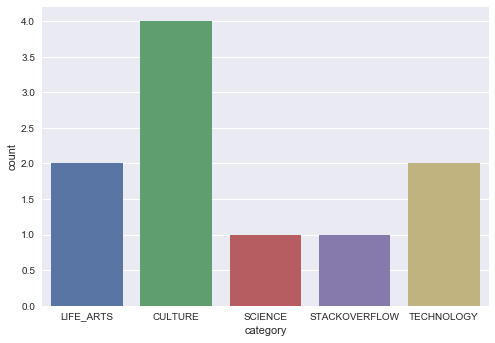

In [8]:
# Category feature distribution
%matplotlib inline
sns.set(font_scale=1)
sns.countplot(x='category', data=df_train)

In [9]:
# Clean host URL to create subcategory
df_train['host']=df_train['host'].apply(lambda x:(x.replace(x ,x.split('.')[0])))
df_test['host']=df_test['host'].apply(lambda x:(x.replace(x ,x.split('.')[0])))

In [10]:
# Change feature name
df_train.columns = df_train.columns.str.replace('host', 'sub_category')
df_test.columns = df_test.columns.str.replace('host', 'sub_category')

In [11]:
# We are trying to figure out if category is redundent due to the sub category
print('\033[1m' + '\033[91m' + '\033[4m' + "sub_categories that mapped to different categories:" +'\033[0m')
arr_sub_category = {}
for sub in df_train['sub_category'].unique():
    data = df_train[df_train['sub_category'] == sub]
    arr = df_train[df_train['sub_category'] == sub]['category'].unique()
    if len(arr) > 1:
        arr_sub_category[sub] = arr
        print(sub, arr)
        # correlation between two features

sub_categories that mapped to different categories:


In [12]:
# Split each sub_category found to be multiplied to more than one category 
# (in order to drop the category feature without loosing any important info)
for key in arr_sub_category.keys():
    for val in arr_sub_category[key]:
        df_train[(df_train['sub_category'] == key) & (df_train['category'] == val)] = df_train[(df_train['sub_category'] == key) & (df_train['category'] == val)].apply(lambda x :x.replace(key, key+'_'+val))


In [13]:
# Checking the new feature:
print(df_train['sub_category'].unique())

['photo' 'rpg' 'electronics' 'judaism' 'graphicdesign' 'stackoverflow'
 'askubuntu' 'gaming' 'serverfault']


*3.sub_categories plot*

C:\Users\elirane\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


gaming         2
judaism        1
electronics    1
serverfault    1
rpg            1
Name: sub_category, dtype: int64

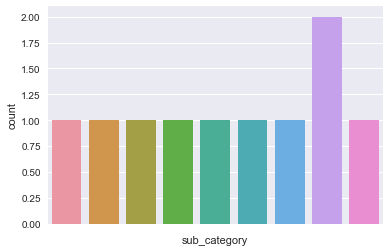

In [14]:
# sub_category feature distribution
%matplotlib inline
g1 = sns.countplot(x='sub_category', data=df_train)
g1.set(xticklabels=[])
g1.set(xlabel="sub_category")
df_train['sub_category'].value_counts().head(5)


*4.correlation sorted list between features*

In [15]:
 # features-lables correlation: 
def corrank(X):
    import itertools
    dff = pd.DataFrame([[(i,j),X.corr().loc[i,j]] for i,j in list(itertools.combinations(X.corr(method = 'spearman'), 2))],columns=['pairs','corr'])    
    print(dff.sort_values(by='corr',ascending=False))

In [16]:
corrank(df_train)

                                                 pairs      corr
313  (question_type_compare, question_type_definition)  1.000000
140  (question_fact_seeking, question_has_commonly_...  1.000000
396   (question_type_procedure, answer_type_procedure)  0.990665
189  (question_interestingness_others, question_int...  0.917211
450            (answer_relevance, answer_satisfaction)  0.855414
224  (question_interestingness_self, question_well_...  0.824089
437    (answer_level_of_information, answer_plausible)  0.809831
445            (answer_plausible, answer_satisfaction)  0.785667
440  (answer_level_of_information, answer_type_inst...  0.773021
444               (answer_plausible, answer_relevance)  0.761454
49   (question_asker_intent_understanding, question...  0.715678
430                 (answer_helpful, answer_plausible)  0.704970
439  (answer_level_of_information, answer_satisfact...  0.702446
202  (question_interestingness_others, question_wel...  0.671729
95     (question_conversa

# Break point!!

### at this point we have two options:
  #### 1. use preprepared train and test data after appending three new features:
    a. q_class - classification of the question by Coarse classes
    b. q_keywords - question's main keywards 
    c. query - question_title grammer features
  #### 2. uncomment the following lines to generate the new features using external nlp adam model

In [17]:
#from adam_qas import adam_script as adam
#dfOut = pd.DataFrame(np.array([["","",""]]))
#dfOut.columns = ["q_class","q_keywords","query"]
#dfOut = dfOut[:-1]

#new_features = adam.activate(df_train['question_title'], dfOut)
#print(new_features)

#df_new_train=pd.concat([df_train,new_features], axis=1, sort=False)
#df_new_test=pd.concat([df_test,new_features], axis=1, sort=False)

#df_new_train.to_csv(PATH+'df_new_train.csv', index=False)
#df_new_test.to_csv(PATH+'df_new_test.csv', index=False)

In [18]:
df_test = pd.read_csv(PATH+'df_new_test.csv')
df_train = pd.read_csv(PATH+'df_new_train.csv')

#### q_class analysis:

C:\Users\elirane\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


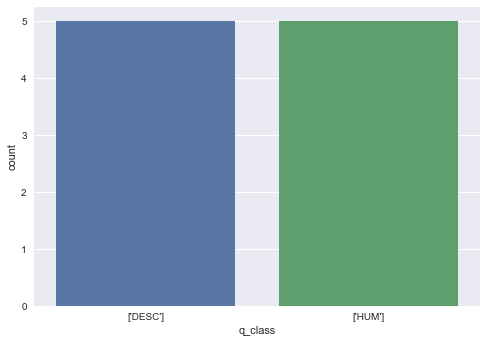

In [19]:
# Category feature distribution
%matplotlib inline
sns.set(font_scale=1)
sns.countplot(x='q_class', data=df_train)

# Model preparation
### Input\Output features selection

In [20]:
# defining input\output categories
output_categories = list(df_train.columns[11:41])
input_categories = list(df_train.columns[[1,2,5,10,41,42,43]])
print('\ninput categories:\n\t', input_categories)
print('\noutput categories:\n\t', output_categories)


input categories:
	 ['question_title', 'question_body', 'answer', 'sub_category', 'q_class', 'q_keywords', 'query']

output categories:
	 ['question_asker_intent_understanding', 'question_body_critical', 'question_conversational', 'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer', 'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice', 'question_type_compare', 'question_type_consequence', 'question_type_definition', 'question_type_entity', 'question_type_instructions', 'question_type_procedure', 'question_type_reason_explanation', 'question_type_spelling', 'question_well_written', 'answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance', 'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 'answer_type_reason_explanation', 'answer_well_written']


In [ ]:
# difining 10 Folds cross-validation
gkf = GroupKFold(n_splits=10).split(X=df_train.question_body, groups=df_train.question_body)

In [21]:
# creating input\output and test tensors
outputs = modBert.compute_output_arrays(df_train, output_categories)
inputs = modBert.compute_input_arays(df_train, input_categories, tokenizer, MAX_SEQUENCE_LENGTH)
test_inputs = modBert.compute_input_arays(df_test, input_categories, tokenizer, MAX_SEQUENCE_LENGTH)

### Train procces

In [ ]:
histories = []
for fold, (train_idx, valid_idx) in enumerate(gkf):
    
    # will actually only do 3 folds (out of 5) to manage < 2h
    if fold < 3:
        K.clear_session()
        model = modBert.bert_model()

        train_inputs = [inputs[i][train_idx] for i in range(3)]
        train_outputs = outputs[train_idx]

        valid_inputs = [inputs[i][valid_idx] for i in range(3)]
        valid_outputs = outputs[valid_idx]

        # history contains two lists of valid and test preds respectively:
        #  [valid_predictions_{fold}, test_predictions_{fold}]
        history = modBert.train_and_predict(model, 
                          train_data=(train_inputs, train_outputs), 
                          valid_data=(valid_inputs, valid_outputs),
                          test_data=test_inputs, 
                          learning_rate=3e-5, epochs=5, batch_size=8,
                          loss_function='binary_crossentropy', fold=fold)

        histories.append(history)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 9 samples
Epoch 1/5


KeyboardInterrupt: 

In [ ]:
מה קורה פה?
כאן אמורים להחזיר את התוצר לתחרות?

# test_predictions = [histories[i].test_predictions for i in range(len(histories))]
# test_predictions = [np.average(test_predictions[i], axis=0) for i in range(len(test_predictions))]
# test_predictions = np.mean(test_predictions, axis=0)

# df_sub =df_sub.assign(results = test_predictions)
# print(df_sub)
# df_sub.to_csv('submission.csv', index=False)